In [ ]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from dataclasses import dataclass
from pathlib import Path
from torchvision import transforms as T
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

import os
import os
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

In [2]:
RUN_NAME = "crossvit_fashion_run1"   # change per experiment if you want
OUT_DIR = os.path.join(os.getcwd(), "outputs", RUN_NAME)
CKPT_DIR = os.path.join(OUT_DIR, "checkpoints")
PLOT_DIR = os.path.join(OUT_DIR, "plots")

os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

print("Outputs will be saved to:", OUT_DIR)


CSV_PATH = "styles.csv"

df = pd.read_csv(
    CSV_PATH,
    engine="python",        # more tolerant parser
    on_bad_lines="skip"     # skips the broken rows
)

print("rows loaded:", len(df))
print(df.columns)


import os
from pathlib import Path
import pandas as pd

IMG_DIR  = "images"   # folder containing 123.jpg etc.

df["id"] = df["id"].astype(str)

img_dir = Path(IMG_DIR)

# map id -> existing image filepath (try common extensions)
exts = [".jpg", ".jpeg", ".png", ".webp"]
def find_image_path(_id: str):
    for e in exts:
        p = img_dir / f"{_id}{e}"
        if p.exists():
            return str(p)
    return None

df["image_path"] = df["id"].map(find_image_path)
paired = df.dropna(subset=["image_path"]).reset_index(drop=True)

print("CSV rows:", len(df))
print("Paired rows:", len(paired))
paired.head()

Outputs will be saved to: c:\Users\Lenovo Loq\Desktop\pytorch\VIT\CrossViT\outputs\crossvit_fashion_run1
rows loaded: 44424
Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')
CSV rows: 44424
Paired rows: 44419


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,images\15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,images\39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,images\59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,images\21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,images\53759.jpg


In [3]:
paired.shape

(44419, 11)

In [4]:
LABEL_COL = "masterCategory"  # or subCategory, articleType, etc.
 
# encode string labels -> integer class ids
classes = sorted(paired[LABEL_COL].dropna().unique().tolist())
cls2id = {c:i for i,c in enumerate(classes)}
paired["label"] = paired[LABEL_COL].map(cls2id).astype(int)

num_classes = len(classes)
print("num_classes:", num_classes)


classes

num_classes: 7


['Accessories',
 'Apparel',
 'Footwear',
 'Free Items',
 'Home',
 'Personal Care',
 'Sporting Goods']

In [5]:
import os
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from torch.utils.data import Dataset
from PIL import Image
import torch

In [6]:
class FashionDFDataset(Dataset):
    def __init__(self, df, transform=None, img_col="image_path", label_col="label", class_to_idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_col = img_col
        self.label_col = label_col

        assert img_col in self.df.columns, f"Missing column: {img_col}"
        assert label_col in self.df.columns, f"Missing column: {label_col}"

        # build / store mapping
        if class_to_idx is None:
            classes = sorted(self.df[label_col].unique())
            self.class_to_idx = {c: i for i, c in enumerate(classes)}
        else:
            self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row[self.img_col]
        label = row[self.label_col]

        # convert label to id
        y = self.class_to_idx[label] if label in self.class_to_idx else int(label)

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(y, dtype=torch.long)




In [7]:
class Dataset:
    image_size = 224
    in_chans = 3

    # CrossViT settings (paper-like defaults for CrossViT-S)
    patch_size_s = 14
    patch_size_l = 16

    embed_dim_s = 192
    embed_dim_l = 384

    # Multi-scale blocks:
    # K blocks total. Each block has depth_s and depth_l transformer layers per branch
    K = 3
    depth_s = 1
    depth_l = 4

    num_heads_s = 6
    num_heads_l = 6

    mlp_ratio = 4.0
    dropout = 0.1

    # cross-attention heads (CLS fusion)
    cross_heads = 4

    # training
    batch_size = 128
    lr = 6e-4
    weight_decay = 0.05
    epochs = 15

    num_workers = 0
    device = "cuda" if torch.cuda.is_available() else "cpu"


In [8]:
dataset = Dataset()
dataset.epochs
dataset.device

'cuda'

In [9]:
train_tfms = T.Compose([
    T.Resize((Dataset.image_size, Dataset.image_size)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])

val_tfms = T.Compose([
    T.Resize((Dataset.image_size, Dataset.image_size)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])

In [10]:
image_dir = "images"  
ds = FashionDFDataset(
    paired,
    transform=train_tfms,     # only pass transform
    label_col="label"         # numeric labels
)


In [11]:
print(len(ds), ds[0][0].shape, ds[0][1])


print(paired.columns.tolist())


44419 torch.Size([3, 224, 224]) tensor(1)
['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image_path', 'label']


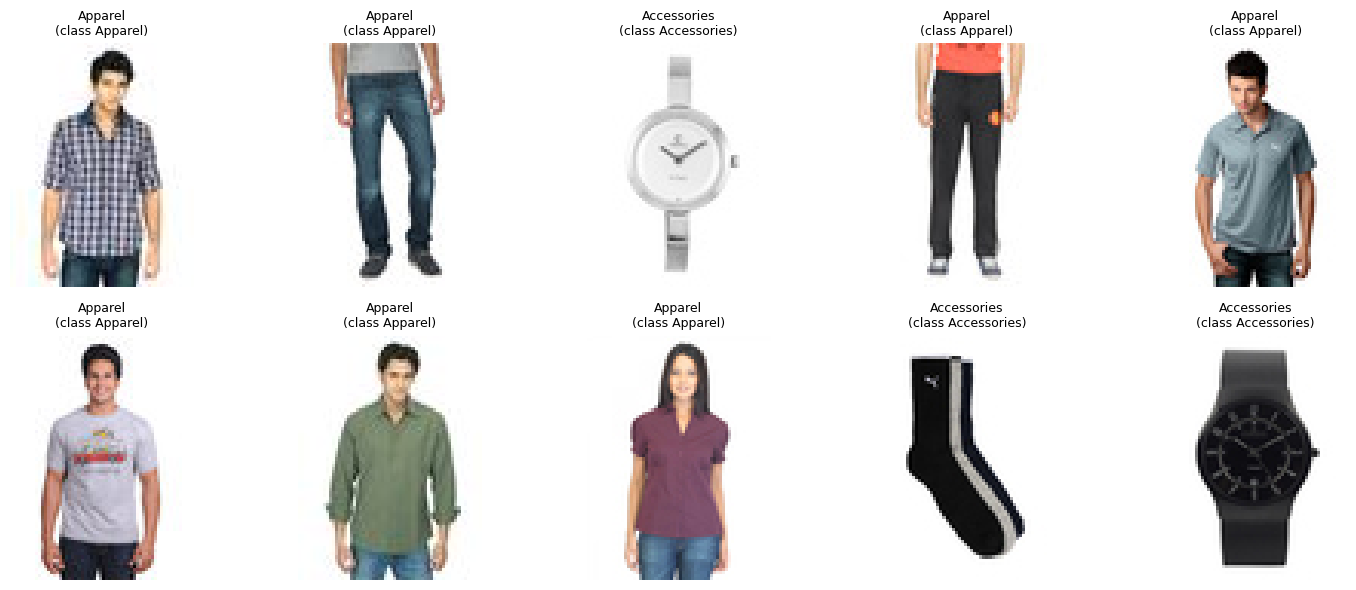

In [15]:
import os
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_DIR = "images"   # change this
LABEL_COL = "masterCategory"    # or whatever you chose

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    row = paired.iloc[i]
    img_id = int(row["id"])
    label_name = row[LABEL_COL]
    label_id = row["masterCategory"]

    img_path = os.path.join(IMAGE_DIR, f"{img_id}.jpg")

    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    ax.set_title(f"{label_name}\n(class {label_id})", fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [18]:
from sklearn.model_selection import train_test_split

SEMANTIC_COL = "masterCategory"   # your original label column (string)

# 1) drop NaNs
paired2 = paired.dropna(subset=[SEMANTIC_COL]).copy()

# 2) remove classes with <2 samples
counts = paired2[SEMANTIC_COL].value_counts()
keep_classes = counts[counts >= 2].index
paired2 = paired2[paired2[SEMANTIC_COL].isin(keep_classes)].reset_index(drop=True)

print("Dropped classes:", (counts[counts < 2]).to_dict())
print("Remaining classes:", paired2[SEMANTIC_COL].nunique(), "Remaining rows:", len(paired2))

# 3) encode -> numeric label
classes = sorted(paired2[SEMANTIC_COL].unique())
cls2id = {c:i for i,c in enumerate(classes)}
paired2["label"] = paired2[SEMANTIC_COL].map(cls2id).astype(int)

# 4) stratified split using numeric labels
train_df, val_df = train_test_split(
    paired2,
    test_size=0.1,
    random_state=42,
    stratify=paired2["label"]
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df), "Num classes:", len(classes))

Dropped classes: {'Home': 1}
Remaining classes: 6 Remaining rows: 44418
Train: 39976 Val: 4442 Num classes: 6


In [ ]:
train_ds = FashionDFDataset(train_df, transform=train_tfms)
val_ds   = FashionDFDataset(val_df,   transform=val_tfms)

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=128,          # or 256 if VRAM allows
    shuffle=True,
    num_workers=16,          # A100 nodes usually have many CPU cores
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4        # important for very fast GPUs
)

val_loader = DataLoader(
    val_ds,
    batch_size=128,
    shuffle=False,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)


xb, yb = next(iter(train_loader))
print(xb.shape, yb.shape)
print("Device:", Dataset.device)

In [ ]:
class PatchEmbedding(nn.Module):
    """
    Conv2d patch embedding (CrossViT-friendly):
      (B,C,H,W) -> (B,D, H//P, W//P) -> flatten -> (B, N, D)

    NOTE:
    - We do NOT force H,W to be divisible by P (paper can tolerate border drop).
    - num_patches is computed dynamically from the actual output size.
    """
    def __init__(self, patch_size: int, in_chans: int, embed_dim: int):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(
            in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            bias=True
        )

    def forward(self, x):
        # x: (B,C,H,W)
        x = self.proj(x)                 # (B, D, H//P, W//P)  (floor if not divisible)
        B, D, Hp, Wp = x.shape
        x = x.flatten(2).transpose(1, 2) # (B, N, D) where N = Hp*Wp
        num_patches = Hp * Wp
        return x, num_patches            # tokens, N


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, attn_dropout=0.0, proj_dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, 3 * embed_dim, bias=True)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_dropout)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x)  # (B,N,3D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3,B,heads,N,head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B,heads,N,N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn) 

        out = attn @ v                                  # (B,heads,N,head_dim)
        out = out.transpose(1, 2).reshape(B, N, D)       # (B,N,D)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out




In [ ]:
class MLP(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.drop1(self.act(self.fc1(x)))
        x = self.drop2(self.fc2(x))
        return x

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_hidden, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            attn_dropout=dropout,
            proj_dropout=dropout
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_hidden, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [ ]:
# =========================
# CROSS ATTENTION (CLS-ONLY)
# =========================
class CrossAttentionCLS(nn.Module):
    """
    CrossViT fusion:
    - Only CLS token is updated
    - CLS from target branch queries [projected target CLS + other-branch patch tokens]
    - then back-project to target dim

    This matches the paper's idea:
    CLS is the only query to keep fusion efficient and stable.
    """
    def __init__(self, dim_q, dim_kv, num_heads, dropout=0.1):
        super().__init__()
        # project target CLS to kv-dim so we can concatenate with other branch tokens
        self.f = nn.Linear(dim_q, dim_kv)
        # back project to target dim
        self.g = nn.Linear(dim_kv, dim_q)

        self.norm = nn.LayerNorm(dim_kv)

        # do attention in dim_kv space
        assert dim_kv % num_heads == 0, "dim_kv must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim_kv // num_heads
        self.scale = self.head_dim ** -0.5

        self.q = nn.Linear(dim_kv, dim_kv)
        self.k = nn.Linear(dim_kv, dim_kv)
        self.v = nn.Linear(dim_kv, dim_kv)

        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim_kv, dim_kv)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, cls_q, patch_other):
        """
        cls_q:      (B,1,dim_q)      CLS token from target branch
        patch_other:(B,N,dim_kv)     patch tokens from other branch
        returns:    (B,1,dim_q)      updated CLS token in target dim
        """
        # concat: [ f(cls_q) || patch_other ] in kv space
        cls_kv = self.f(cls_q)                      # (B,1,dim_kv)
        x = torch.cat([cls_kv, patch_other], dim=1) # (B,1+N,dim_kv)

        x = self.norm(x)

        # CLS-only query
        q = self.q(x[:, :1, :])                     # (B,1,dim_kv)
        k = self.k(x)                               # (B,1+N,dim_kv)
        v = self.v(x)                               # (B,1+N,dim_kv)

        # reshape to heads
        B, QN, D = q.shape # B,1,dim_kv
        _, KN, _ = k.shape
        q = q.view(B, QN, self.num_heads, self.head_dim).transpose(1, 2)  # (B,h,1,hd)
        k = k.view(B, KN, self.num_heads, self.head_dim).transpose(1, 2)  # (B,h,KN,hd)
        v = v.view(B, KN, self.num_heads, self.head_dim).transpose(1, 2)  # (B,h,KN,hd)

        attn = (q @ k.transpose(-2, -1)) * self.scale   # (B,h,1,KN)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v                                  # (B,h,1,hd)
        out = out.transpose(1, 2).contiguous().view(B, 1, D)  # (B,1,dim_kv)

        out = self.proj_drop(self.proj(out))            # (B,1,dim_kv)

        # residual in kv-space then back to q-space
        cls_updated_kv = cls_kv + out                   # (B,1,dim_kv)
        cls_updated_q  = self.g(cls_updated_kv)         # (B,1,dim_q)
        return cls_updated_q


In [ ]:
class MultiScaleBlock(nn.Module):
    """
    One CrossViT multi-scale block:
      - run depth_s transformer blocks on small branch
      - run depth_l transformer blocks on large branch
      - cross-attn fusion both ways, updating CLS only
    """
    def __init__(self, dim_s, dim_l, depth_s, depth_l,
                 heads_s, heads_l, mlp_ratio=4.0,
                 cross_heads=4, dropout=0.1):
        super().__init__()

        mlp_hidden_s = int(dim_s * mlp_ratio)
        mlp_hidden_l = int(dim_l * mlp_ratio)

        self.s_blocks = nn.Sequential(*[
            TransformerEncoderBlock(dim_s, heads_s, mlp_hidden_s, dropout)
            for _ in range(depth_s)
        ])
        self.l_blocks = nn.Sequential(*[
            TransformerEncoderBlock(dim_l, heads_l, mlp_hidden_l, dropout)
            for _ in range(depth_l)
        ])

        # Fusion: L CLS attends to S patches, and S CLS attends to L patches
        self.ca_l = CrossAttentionCLS(dim_q=dim_l, dim_kv=dim_s, num_heads=cross_heads, dropout=dropout)
        self.ca_s = CrossAttentionCLS(dim_q=dim_s, dim_kv=dim_l, num_heads=cross_heads, dropout=dropout)

    def forward(self, xs, xl):
        # xs: (B,1+Ns,dim_s), xl: (B,1+Nl,dim_l)
        xs = self.s_blocks(xs)
        xl = self.l_blocks(xl)

        cls_s, patch_s = xs[:, :1, :], xs[:, 1:, :]
        cls_l, patch_l = xl[:, :1, :], xl[:, 1:, :]

        # update only CLS (paper trick)
        cls_l = cls_l + self.ca_l(cls_l, patch_s)
        cls_s = cls_s + self.ca_s(cls_s, patch_l)

        xs = torch.cat([cls_s, patch_s], dim=1)
        xl = torch.cat([cls_l, patch_l], dim=1)
        return xs, xl


In [ ]:
import torch
import torch.nn as nn


class CrossViT(nn.Module):
    """
    CrossViT top-level model (2 branches + K multi-scale blocks + 2 heads averaged).

    Assumes you already defined:
      - PatchEmbedding(img_size, patch_size, in_chans, embed_dim) -> (B, N, D)
        with attribute: .num_patches
      - MultiScaleBlock(dim_s, dim_l, depth_s, depth_l, heads_s, heads_l, ...)
        forward(xs, xl) -> (xs, xl)
    """
    def __init__(
        self,
        image_size=224,
        in_chans=3,
        num_classes=10,
        patch_size_s=14,   # you set 14 for divisibility with 224
        patch_size_l=16,
        embed_dim_s=192,
        embed_dim_l=384,
        K=3,
        depth_s=1,
        depth_l=4,
        num_heads_s=6,
        num_heads_l=6,
        mlp_ratio=4.0,
        cross_heads=4,
        dropout=0.1,
    ):
        super().__init__()

        # -------------------------
        # Patch embeddings (2 branches)
        # -------------------------
        self.patch_embed_s = PatchEmbedding( patch_size_s, in_chans, embed_dim_s)
        self.patch_embed_l = PatchEmbedding(patch_size_l, in_chans, embed_dim_l)
        


        Ns = (image_size // patch_size_s) ** 2
        Nl = (image_size // patch_size_l) ** 2


        # -------------------------
        # CLS + Positional embeddings (2 branches)
        # -------------------------
        self.cls_s = nn.Parameter(torch.zeros(1, 1, embed_dim_s))
        self.cls_l = nn.Parameter(torch.zeros(1, 1, embed_dim_l))

        self.pos_s = nn.Parameter(torch.zeros(1, 1 + Ns, embed_dim_s))
        self.pos_l = nn.Parameter(torch.zeros(1, 1 + Nl, embed_dim_l))
        self.pos_drop = nn.Dropout(dropout)

        # -------------------------
        # Multi-scale blocks: MUST be ModuleList (blocks take (xs, xl))
        # -------------------------
        self.blocks = nn.ModuleList([
            MultiScaleBlock(
                dim_s=embed_dim_s,
                dim_l=embed_dim_l,
                depth_s=depth_s,
                depth_l=depth_l,
                heads_s=num_heads_s,
                heads_l=num_heads_l,
                mlp_ratio=mlp_ratio,
                cross_heads=cross_heads,
                dropout=dropout
            )
            for _ in range(K)
        ])

        # -------------------------
        # Norms + Heads (2 branches, then average logits)
        # -------------------------
        self.norm_s = nn.LayerNorm(embed_dim_s)
        self.norm_l = nn.LayerNorm(embed_dim_l)

        self.head_s = nn.Linear(embed_dim_s, num_classes)
        self.head_l = nn.Linear(embed_dim_l, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_s, std=0.02)
        nn.init.trunc_normal_(self.cls_l, std=0.02)
        nn.init.trunc_normal_(self.pos_s, std=0.02)
        nn.init.trunc_normal_(self.pos_l, std=0.02)

        nn.init.trunc_normal_(self.head_s.weight, std=0.02)
        nn.init.trunc_normal_(self.head_l.weight, std=0.02)
        nn.init.zeros_(self.head_s.bias)
        nn.init.zeros_(self.head_l.bias)

    def forward(self, x):
        """
        x: (B, C, H, W)
        returns logits: (B, num_classes)
        """
        B = x.size(0)

        # Patch tokens
        xs, Ns = self.patch_embed_s(x)   # xs: (B, Ns, Ds)
        xl, Nl = self.patch_embed_l(x)   # xl: (B, Nl, Dl)


        # Prepend CLS tokens
        cls_s = self.cls_s.expand(B, -1, -1)  # (B,1,Ds)
        cls_l = self.cls_l.expand(B, -1, -1)  # (B,1,Dl)
        xs = torch.cat([cls_s, xs], dim=1)    # (B,1+Ns,Ds)
        xl = torch.cat([cls_l, xl], dim=1)    # (B,1+Nl,Dl)

        # Add positional embeddings
        xs = self.pos_drop(xs + self.pos_s)   # (B,1+Ns,Ds)
        xl = self.pos_drop(xl + self.pos_l)   # (B,1+Nl,Dl)

        # K multi-scale blocks
        for blk in self.blocks:
            xs, xl = blk(xs, xl)

        # Final norms
        xs = self.norm_s(xs)
        xl = self.norm_l(xl)

        # CLS outputs -> heads
        logits_s = self.head_s(xs[:, 0])      # (B,num_classes)
        logits_l = self.head_l(xl[:, 0])      # (B,num_classes)

        # Average predictions (paper-style 2-head ensemble)
        logits = (logits_s + logits_l) / 2.0
        return logits


In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = dataset.epochs
device = dataset.device

@torch.no_grad()
def validate_one_epoch(model, loader, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        bs = x.size(0)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        total_loss += loss.item() * bs
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += bs

    return total_loss / total_samples, total_correct / total_samples




import torch
import torch.nn.functional as F

from tqdm import tqdm
import torch.nn.functional as F

def train_one_epoch(model, loader, optimizer, device):
    model.train()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(
        loader,
        desc="Train",
        leave=False,
        dynamic_ncols=True
    )

    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_samples += bs

        # live stats (running averages)
        pbar.set_postfix({
            "loss": f"{total_loss / total_samples:.4f}",
            "acc":  f"{total_correct / total_samples:.4f}"
        })

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples
    return avg_loss, avg_acc



model = CrossViT(
    image_size=Dataset.image_size,
    in_chans=Dataset.in_chans,
    num_classes=num_classes,
    patch_size_s=Dataset.patch_size_s,
    patch_size_l=Dataset.patch_size_l,
    embed_dim_s=Dataset.embed_dim_s,
    embed_dim_l=Dataset.embed_dim_l,
    K=Dataset.K,
    depth_s=Dataset.depth_s,
    depth_l=Dataset.depth_l,
    num_heads_s=Dataset.num_heads_s,
    num_heads_l=Dataset.num_heads_l,
    mlp_ratio=Dataset.mlp_ratio,
    cross_heads=Dataset.cross_heads,
    dropout=Dataset.dropout,
).to(Dataset.device)

optimizer = torch.optim.AdamW(model.parameters(), lr=Dataset.lr, weight_decay=Dataset.weight_decay)










In [ ]:
import torch

best_val_acc = 0.0
best_epoch = 0
save_path = "best_crossvit.pth"

for epoch in range(1, epochs + 1):
    # ---- train ----
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, device
    )

    # ---- validate ----
    val_loss, val_acc = validate_one_epoch(
        model, val_loader, device
    )

    # ---- store history ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # ---- print epoch summary ----
    print(
        f"Epoch {epoch:02d}/{epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

    # ---- save best model ----
    best_ckpt_path = os.path.join(CKPT_DIR, "best.pth")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
            "cls2id": cls2id,
        }, best_ckpt_path)

        print(f" Saved BEST model @ epoch {epoch} (val_acc={val_acc:.4f})")


print(f"\n Training complete. Best Val Acc = {best_val_acc:.4f} at epoch {best_epoch}")

final_ckpt_path = os.path.join(CKPT_DIR, "final.pth")
torch.save(model.state_dict(), final_ckpt_path)
print(f" Saved FINAL model to {final_ckpt_path}")

@torch.no_grad()
def predict_image(model, image_path, transform, idx_to_class, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    logits = model(x)
    probs = F.softmax(logits, dim=1)[0]
    topk = torch.topk(probs, k=min(5, probs.numel()))
    results = [(idx_to_class[i.item()], topk.values[j].item()) for j, i in enumerate(topk.indices)]
    return results

idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}
# print(predict_image(model, "some_product.jpg", val_tfms, idx_to_class, Dataset.device))


In [ ]:
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

os.makedirs(PLOT_DIR, exist_ok=True)

epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CrossViT – Loss Curve")
plt.legend()
plt.grid(True)

plot_path = os.path.join(PLOT_DIR, "loss_curve.png")
plt.savefig(plot_path, dpi=200, bbox_inches="tight")
plt.close()

print("📉 Loss curve saved to", plot_path, "| exists?", os.path.exists(plot_path))


In [ ]:
import os, json

import json

metrics = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs,
    "best_val_acc": best_val_acc,
    "best_epoch": best_epoch,
}

with open(os.path.join(OUT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print("📊 Metrics saved")


In [ ]:
import json, os

os.makedirs(OUT_DIR, exist_ok=True)

unique_ids = sorted(train_df["label"].unique())   # or df_train
id2cls = {int(i): str(i) for i in unique_ids}     # if you don't have names
cls2id = {v: k for k, v in id2cls.items()}

with open(os.path.join(OUT_DIR, "cls2id.json"), "w") as f:
    json.dump(cls2id, f, indent=2)

with open(os.path.join(OUT_DIR, "id2cls.json"), "w") as f:
    json.dump(id2cls, f, indent=2)